In [387]:
#version 2 of the vehicle dataset 

#question
#we want to create segments for marketing on the website by different type of vechile 

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



from scipy import stats
from scipy.stats import zscore


def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])


sns.set()
sns.set_style("whitegrid") #for whitebackground charts


In [479]:
#this is for ordering the clusters later on
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [389]:
df =  pd.read_csv('vehicle_reduced.csv'
                     ,sep=','
                    
                     )

In [390]:
df.drop(['Unnamed: 0','county'],axis=1,inplace=True)#mistake on my export


In [391]:
for y in df.columns:
    if(df[y].dtype == np.float64 or df[y].dtype == np.int64):
          df[y] = df[y].fillna(0)
    if(df[y].dtype == np.object):
           df[y] = df[y].fillna('Missing') 
    else:
        df[y] =df[y]  #this does not clean booleans or dates   

In [392]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7088746062,greensboro,10299,2012.0,acura,tl,Missing,Missing,gas,90186.0,clean,automatic,Missing,Missing,other,blue,nc
1,7088745301,greensboro,0,2011.0,bmw,335,Missing,6 cylinders,gas,115120.0,clean,automatic,rwd,Missing,convertible,blue,nc
2,7088744126,greensboro,9500,2011.0,jaguar,xf,excellent,Missing,gas,85000.0,clean,automatic,Missing,Missing,Missing,blue,nc
3,7088743681,greensboro,3995,2004.0,honda,element,Missing,Missing,gas,212526.0,clean,automatic,fwd,Missing,SUV,orange,nc
4,7074612539,lincoln,41988,2016.0,chevrolet,silverado k2500hd,Missing,Missing,gas,0.0,clean,automatic,Missing,Missing,Missing,Missing,ne


In [393]:
df.drop(['condition','cylinders','region'],axis=1,inplace=True)#mistake on my export
df.head()

,id,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7088746062,10299,2012.0,acura,tl,gas,90186.0,clean,automatic,Missing,Missing,other,blue,nc
1,7088745301,0,2011.0,bmw,335,gas,115120.0,clean,automatic,rwd,Missing,convertible,blue,nc
2,7088744126,9500,2011.0,jaguar,xf,gas,85000.0,clean,automatic,Missing,Missing,Missing,blue,nc
3,7088743681,3995,2004.0,honda,element,gas,212526.0,clean,automatic,fwd,Missing,SUV,orange,nc
4,7074612539,41988,2016.0,chevrolet,silverado k2500hd,gas,0.0,clean,automatic,Missing,Missing,Missing,Missing,ne


In [394]:
#drop anything with no price and no mileage
display(df.shape)
df.drop(df[df['price']<=1].index, inplace=True)
df.drop(df[df['odometer']<=1].index, inplace=True)
display(df.shape)

(539759, 14)

(402444, 14)

In [395]:
#remove any unlikley numbers
df.drop(df[df['odometer']>=1000000].index, inplace=True) #maybe some legitamate but its fine
df.drop(df[df['price']>=150000].index, inplace=True) # secound hand cars
display(df.shape)

(401823, 14)

In [396]:
for y in df.columns:
    if(df[y].dtype == np.float64 or df[y].dtype == np.int64):
          df[y] = df[y].fillna(0)
    if(df[y].dtype == np.object):
           df[y] = df[y].fillna('Missing') 
    else:
        df[y] =df[y]  #this does not clean booleans or dates   

In [397]:
cols= ['price','year','odometer']

for x in cols:
    df[x] = df[x].astype(int)
    
df.head()    

,id,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,7088746062,10299,2012,acura,tl,gas,90186,clean,automatic,Missing,Missing,other,blue,nc
2,7088744126,9500,2011,jaguar,xf,gas,85000,clean,automatic,Missing,Missing,Missing,blue,nc
3,7088743681,3995,2004,honda,element,gas,212526,clean,automatic,fwd,Missing,SUV,orange,nc
5,7088741557,12995,2015,kia,sportage,gas,85127,clean,automatic,4wd,Missing,wagon,Missing,nc
6,7088741418,10995,2014,chevrolet,traverse,gas,112383,clean,automatic,fwd,Missing,SUV,black,nc


In [398]:
#collist = df.select_dtypes(include=[np.number]).columns
collist=['price','odometer'] #override

for x in collist:
    df[x+'_z'] = zscore(df[x])
    df[x+'_z_abs'] = np.floor(np.abs(zscore(df[x])))
    
#df[numeric_cols].apply(zscore)

df.head()

,id,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_z,price_z_abs,odometer_z,odometer_z_abs
0,7088746062,10299,2012,acura,tl,gas,90186,clean,automatic,Missing,Missing,other,blue,nc,-0.377672,0.0,-0.160285,0.0
2,7088744126,9500,2011,jaguar,xf,gas,85000,clean,automatic,Missing,Missing,Missing,blue,nc,-0.448152,0.0,-0.238426,0.0
3,7088743681,3995,2004,honda,element,gas,212526,clean,automatic,fwd,Missing,SUV,orange,nc,-0.933751,0.0,1.683095,1.0
5,7088741557,12995,2015,kia,sportage,gas,85127,clean,automatic,4wd,Missing,wagon,Missing,nc,-0.139856,0.0,-0.236512,0.0
6,7088741418,10995,2014,chevrolet,traverse,gas,112383,clean,automatic,fwd,Missing,SUV,black,nc,-0.316277,0.0,0.174172,0.0


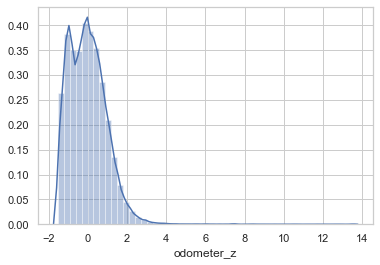

In [399]:
sns.distplot(df['odometer_z'])

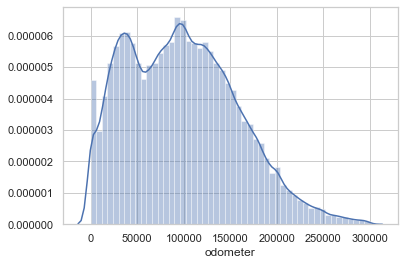

In [400]:
sns.distplot(df[df['odometer_z']<=3]['odometer'])

In [401]:
display(df.shape)
df.drop(df[df['odometer_z_abs']>=3].index, inplace=True)
display(df.shape)


(401823, 18)

(399323, 18)

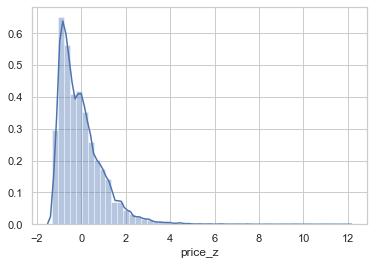

In [402]:
sns.distplot(df['price_z'])

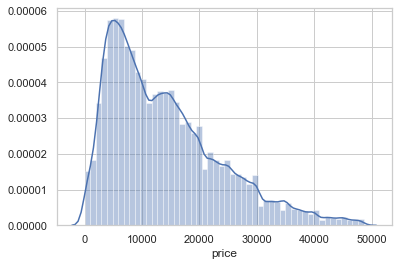

In [403]:
sns.distplot(df[df['price_z']<=3]['price'])

In [404]:
display(df.shape)
df.drop(df[df['price_z']>=3].index, inplace=True)
display(df.shape)

(399323, 18)

(393880, 18)

In [405]:
#look at the id number
df.head()

,id,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_z,price_z_abs,odometer_z,odometer_z_abs
0,7088746062,10299,2012,acura,tl,gas,90186,clean,automatic,Missing,Missing,other,blue,nc,-0.377672,0.0,-0.160285,0.0
2,7088744126,9500,2011,jaguar,xf,gas,85000,clean,automatic,Missing,Missing,Missing,blue,nc,-0.448152,0.0,-0.238426,0.0
3,7088743681,3995,2004,honda,element,gas,212526,clean,automatic,fwd,Missing,SUV,orange,nc,-0.933751,0.0,1.683095,1.0
5,7088741557,12995,2015,kia,sportage,gas,85127,clean,automatic,4wd,Missing,wagon,Missing,nc,-0.139856,0.0,-0.236512,0.0
6,7088741418,10995,2014,chevrolet,traverse,gas,112383,clean,automatic,fwd,Missing,SUV,black,nc,-0.316277,0.0,0.174172,0.0


In [406]:
df['id_short'] = df['id'].astype(str).str.slice(0,4).astype(int) #this seems a really poor way to do this
df.head().T

,0,2,3,5,6
id,7088746062,7088744126,7088743681,7088741557,7088741418
price,10299,9500,3995,12995,10995
year,2012,2011,2004,2015,2014
manufacturer,acura,jaguar,honda,kia,chevrolet
model,tl,xf,element,sportage,traverse
fuel,gas,gas,gas,gas,gas
odometer,90186,85000,212526,85127,112383
title_status,clean,clean,clean,clean,clean
transmission,automatic,automatic,automatic,automatic,automatic
drive,Missing,Missing,fwd,4wd,fwd


In [407]:
df.groupby('id_short').size()

id_short
7065        1
7069        1
7074     5008
7075     9175
7076     5624
7077     8609
7078     9058
7079    10830
7080     8892
7081     8524
7082    12648
7083    13953
7084    14991
7085    13919
7086    20130
7087    25114
7088    30216
7089    19522
7090    36121
7091    37302
7092    62679
7093    41563
dtype: int64

In [408]:
df.drop(df[df['id_short']<=7069].index, inplace=True)
display(df.shape)

(393878, 19)

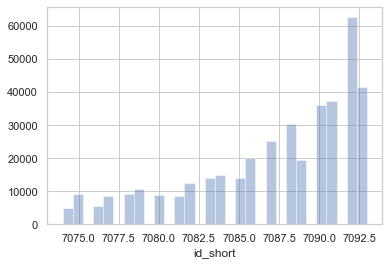

In [409]:
sns.distplot(df['id_short'], kde=False, bins=30)

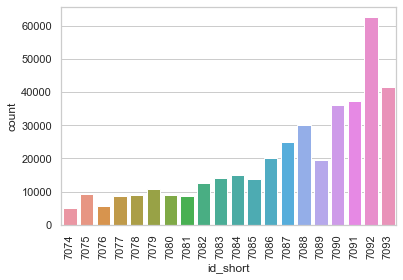

In [410]:
ax = sns.countplot(x="id_short", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [411]:
df.groupby('year').size()

year
0         778
1908        3
1912        4
1914        1
1918        4
        ...  
2017    32101
2018    18835
2019    11205
2020     1167
2021        8
Length: 101, dtype: int64

In [412]:
display(df.shape)
df.drop(df[df['year']<=1990].index, inplace=True)
display(df.shape)



(393878, 19)

(387311, 19)

In [413]:
df.drop(df[df['year']<=2000].index, inplace=True)
display(df.shape)


(371014, 19)

In [414]:
df.groupby('year').size()


year
2001     5234
2002     6731
2003     8826
2004    11295
2005    13241
2006    16430
2007    19813
2008    22178
2009    15151
2010    19082
2011    24421
2012    26751
2013    29175
2014    28644
2015    29996
2016    30730
2017    32101
2018    18835
2019    11205
2020     1167
2021        8
dtype: int64

In [415]:
df.drop(df[df['year']>=2020].index, inplace=True)
display(df.shape)

(369839, 19)

In [416]:
df.head()

,id,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short
0,7088746062,10299,2012,acura,tl,gas,90186,clean,automatic,Missing,Missing,other,blue,nc,-0.377672,0.0,-0.160285,0.0,7088
2,7088744126,9500,2011,jaguar,xf,gas,85000,clean,automatic,Missing,Missing,Missing,blue,nc,-0.448152,0.0,-0.238426,0.0,7088
3,7088743681,3995,2004,honda,element,gas,212526,clean,automatic,fwd,Missing,SUV,orange,nc,-0.933751,0.0,1.683095,1.0,7088
5,7088741557,12995,2015,kia,sportage,gas,85127,clean,automatic,4wd,Missing,wagon,Missing,nc,-0.139856,0.0,-0.236512,0.0,7088
6,7088741418,10995,2014,chevrolet,traverse,gas,112383,clean,automatic,fwd,Missing,SUV,black,nc,-0.316277,0.0,0.174172,0.0,7088


In [417]:
df.groupby('manufacturer').size()


manufacturer
Missing             9146
acura               3016
alfa-romeo            39
aston-martin          11
audi                4711
bmw                11076
buick               5335
cadillac            5541
chevrolet          52578
chrysler            6213
dodge              12610
fiat                 765
ford               66039
gmc                16456
harley-davidson      150
honda              18951
hyundai             9656
infiniti            3204
jaguar               732
jeep               17959
kia                 7395
land rover            14
lexus               4788
lincoln             2370
mazda               4672
mercedes-benz       8205
mercury             1112
mini                1996
mitsubishi          1896
nissan             21153
pontiac             2118
porche                 7
ram                18570
rover               1439
saturn              1179
subaru              9252
tesla                 85
toyota             28975
volkswagen          8220
volvo       

In [418]:
df.drop(df[df['manufacturer']=='Missing'].index, inplace=True)
df.shape


(360693, 19)

In [419]:
a = df.groupby(['model'])['id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

display(df.shape)
display(a)
display(a['count'].sum())

display(a[a['count']<=100]['count'].sum())
#this field would need signficant cleaning to work 

(360693, 19)

,model,count
7974,f-150,7998
16772,silverado 1500,5152
62,1500,4652
16767,silverado,3346
2366,Missing,3173
...,...,...
9423,f350 super duty whi,1
9426,"f350 super duty, lariat",1
9428,f350 supercrew,1
9429,f350 supercrew lariat,1


360693

121428

In [420]:
df.drop(['model'],axis=1,inplace=True)#mistake on my export


In [421]:
df.groupby('fuel').size()

fuel
Missing       2510
diesel       24949
electric       659
gas         317503
hybrid        3322
other        11750
dtype: int64

In [422]:
df.drop(df[df['fuel'].isin(['Missing','electric','hybrid','other'])].index, inplace=True)
display(df.groupby('fuel').size())

fuel
diesel     24949
gas       317503
dtype: int64

In [423]:
df.head()

,id,price,year,manufacturer,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short
0,7088746062,10299,2012,acura,gas,90186,clean,automatic,Missing,Missing,other,blue,nc,-0.377672,0.0,-0.160285,0.0,7088
2,7088744126,9500,2011,jaguar,gas,85000,clean,automatic,Missing,Missing,Missing,blue,nc,-0.448152,0.0,-0.238426,0.0,7088
3,7088743681,3995,2004,honda,gas,212526,clean,automatic,fwd,Missing,SUV,orange,nc,-0.933751,0.0,1.683095,1.0,7088
5,7088741557,12995,2015,kia,gas,85127,clean,automatic,4wd,Missing,wagon,Missing,nc,-0.139856,0.0,-0.236512,0.0,7088
6,7088741418,10995,2014,chevrolet,gas,112383,clean,automatic,fwd,Missing,SUV,black,nc,-0.316277,0.0,0.174172,0.0,7088


In [424]:
df.groupby('title_status').size()


title_status
Missing         1383
clean         326094
lien            2242
missing           77
parts only        45
rebuilt         9105
salvage         3506
dtype: int64

In [425]:
df.drop(df[df['title_status']!='clean'].index, inplace=True)
df.shape


(326094, 18)

In [426]:
df.drop(['title_status'],axis=1,inplace=True)


In [427]:
df.groupby('transmission').size()


transmission
Missing        2487
automatic    290674
manual        14668
other         18265
dtype: int64

In [428]:
df.drop(df[df['transmission']=='Missing'].index, inplace=True)
df.shape

(323607, 17)

In [429]:
df.groupby('drive').size()

drive
4wd        122805
Missing     66746
fwd         91514
rwd         42542
dtype: int64

In [430]:
df.drop(df[df['drive']=='Missing'].index, inplace=True)
df.shape

(256861, 17)

In [431]:
df.groupby('size').size()

size
Missing        156943
compact         12685
full-size       56096
mid-size        29436
sub-compact      1701
dtype: int64

In [432]:
df.drop(['size'],axis=1,inplace=True)
df.head()

,id,price,year,manufacturer,fuel,odometer,transmission,drive,type,paint_color,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short
3,7088743681,3995,2004,honda,gas,212526,automatic,fwd,SUV,orange,nc,-0.933751,0.0,1.683095,1.0,7088
5,7088741557,12995,2015,kia,gas,85127,automatic,4wd,wagon,Missing,nc,-0.139856,0.0,-0.236512,0.0,7088
6,7088741418,10995,2014,chevrolet,gas,112383,automatic,fwd,SUV,black,nc,-0.316277,0.0,0.174172,0.0,7088
8,7088737004,3995,2007,toyota,gas,185123,automatic,fwd,convertible,black,nc,-0.933751,0.0,1.270196,1.0,7088
10,7088732376,7995,2008,nissan,gas,162214,automatic,fwd,pickup,red,nc,-0.580909,0.0,0.925010,0.0,7088


In [433]:
a = df.groupby(['type'])['id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)

display(a)

df.drop(df[df['type'].isin(['Missing','offroad','bus'])].index, inplace=True)
df.shape

,type,count
1,SUV,58915
10,sedan,56923
9,pickup,31274
11,truck,30782
0,Missing,29540
4,coupe,11271
8,other,8046
13,wagon,7669
5,hatchback,7335
12,van,6420


(226835, 16)

In [434]:
df.drop(['paint_color'],axis=1,inplace=True)


In [435]:
df.head()

,id,price,year,manufacturer,fuel,odometer,transmission,drive,type,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short
3,7088743681,3995,2004,honda,gas,212526,automatic,fwd,SUV,nc,-0.933751,0.0,1.683095,1.0,7088
5,7088741557,12995,2015,kia,gas,85127,automatic,4wd,wagon,nc,-0.139856,0.0,-0.236512,0.0,7088
6,7088741418,10995,2014,chevrolet,gas,112383,automatic,fwd,SUV,nc,-0.316277,0.0,0.174172,0.0,7088
8,7088737004,3995,2007,toyota,gas,185123,automatic,fwd,convertible,nc,-0.933751,0.0,1.270196,1.0,7088
10,7088732376,7995,2008,nissan,gas,162214,automatic,fwd,pickup,nc,-0.580909,0.0,0.925010,0.0,7088


create a training / test split for kmeans 
I should actually use my id_short variable as this will reflect new listings being added to the file 

In [436]:
df.groupby('id_short').size()

id_short
7074     2864
7075     5555
7076     3134
7077     4823
7078     5450
7079     6256
7080     5067
7081     4801
7082     7160
7083     8256
7084     8664
7085     7909
7086    11782
7087    14709
7088    17791
7089    10757
7090    20943
7091    20558
7092    36388
7093    23968
dtype: int64

In [437]:
df['testtrain'] = np.where(df['id_short']<=7091,'Train','Test')

In [438]:
df.groupby('testtrain').size()

testtrain
Test      60356
Train    166479
dtype: int64

In [439]:
df.groupby(['testtrain','id_short']).size()

testtrain  id_short
Test       7092        36388
           7093        23968
Train      7074         2864
           7075         5555
           7076         3134
           7077         4823
           7078         5450
           7079         6256
           7080         5067
           7081         4801
           7082         7160
           7083         8256
           7084         8664
           7085         7909
           7086        11782
           7087        14709
           7088        17791
           7089        10757
           7090        20943
           7091        20558
dtype: int64

In [440]:
#try pd.get_dummies 
df_gd = pd.get_dummies(data = df, columns = ['fuel', 'transmission', 'drive', 'type'] ) #add manufacturer later

df_gd.head().T

,3,5,6,8,10
id,7088743681,7088741557,7088741418,7088737004,7088732376
price,3995,12995,10995,3995,7995
year,2004,2015,2014,2007,2008
manufacturer,honda,kia,chevrolet,toyota,nissan
odometer,212526,85127,112383,185123,162214
state,nc,nc,nc,nc,nc
price_z,-0.933751,-0.139856,-0.316277,-0.933751,-0.580909
price_z_abs,0,0,0,0,0
odometer_z,1.6831,-0.236512,0.174172,1.2702,0.92501
odometer_z_abs,1,0,0,1,0


use min max scaler instead

In [441]:
df_gd.columns

Index(['id', 'price', 'year', 'manufacturer', 'odometer', 'state', 'price_z',
       'price_z_abs', 'odometer_z', 'odometer_z_abs', 'id_short', 'testtrain',
       'fuel_diesel', 'fuel_gas', 'transmission_automatic',
       'transmission_manual', 'transmission_other', 'drive_4wd', 'drive_fwd',
       'drive_rwd', 'type_SUV', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_mini-van', 'type_other', 'type_pickup',
       'type_sedan', 'type_truck', 'type_van', 'type_wagon'],
      dtype='object')

In [442]:
df_gd.drop(['state','price_z',
       'price_z_abs', 'odometer_z', 'odometer_z_abs','manufacturer'],axis=1,inplace=True)

df_gd.set_index('id',inplace=True)

In [443]:
display(df_gd.shape)
df_gd_test = df_gd[df_gd['testtrain']=='Test'].copy()
display(df_gd_test.shape)


df_gd_train = df_gd[df_gd['testtrain']=='Train'].copy()
display(df_gd_train.shape)

df_gd_test.drop(['id_short','testtrain'],axis=1,inplace=True)
df_gd_train.drop(['id_short','testtrain'],axis=1,inplace=True)

(226835, 24)

(60356, 24)

(166479, 24)

In [444]:
df_gd_train.head().T

id,7088743681,7088741557,7088741418,7088737004,7088732376
price,3995,12995,10995,3995,7995
year,2004,2015,2014,2007,2008
odometer,212526,85127,112383,185123,162214
fuel_diesel,0,0,0,0,0
fuel_gas,1,1,1,1,1
transmission_automatic,1,1,1,1,1
transmission_manual,0,0,0,0,0
transmission_other,0,0,0,0,0
drive_4wd,0,1,0,0,0
drive_fwd,1,0,1,1,1


In [445]:
len(df_gd_train.columns)

22

In [446]:
scaler = MinMaxScaler()
scaler.fit(df_gd_train)
data_transformed = scaler.transform(df_gd_train)


In [447]:
data_transformed.shape

(166479, 22)

In [448]:
data_transformed.max() 
#so it has made 1 the max 

1.0

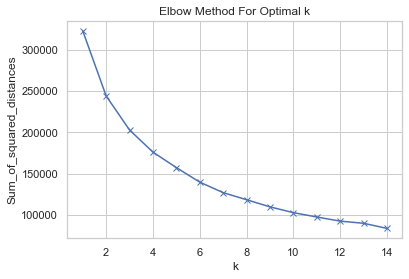

In [449]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [450]:
km = KMeans(n_clusters=9)
df_gd_train['cluster'] = km.fit_predict(data_transformed)


In [451]:
df_gd_train.groupby('cluster').size()

cluster
0    12791
1    29727
2    17176
3    30597
4     6977
5     9588
6    24122
7    21930
8    13571
dtype: int64

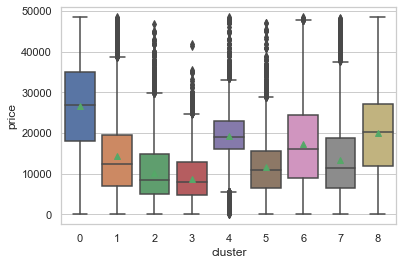

In [452]:
sns.boxplot(x="cluster", y="price", data=df_gd_train, showmeans=True)


In [453]:
#now try this on the test set with the rules from the training set 

scaler.fit(df_gd_test)
data_transformed = scaler.transform(df_gd_test)


In [454]:
df_gd_test['cluster'] = km.predict(data_transformed)#note this is not fit predict 


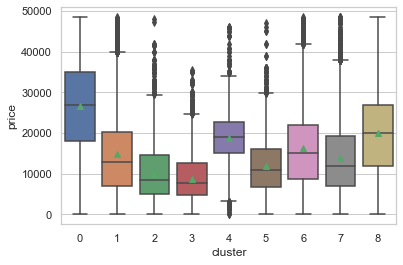

In [455]:
sns.boxplot(x="cluster", y="price", data=df_gd_test, showmeans=True)


In [456]:
df_gd_train.shape

(166479, 23)

In [457]:
df_gd_test.shape

(60356, 23)

In [458]:
#df.drop(['cluster_x','cluster_y'],axis=1,inplace=True)

In [459]:
df.head()

,id,price,year,manufacturer,fuel,odometer,transmission,drive,type,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short,testtrain
3,7088743681,3995,2004,honda,gas,212526,automatic,fwd,SUV,nc,-0.933751,0.0,1.683095,1.0,7088,Train
5,7088741557,12995,2015,kia,gas,85127,automatic,4wd,wagon,nc,-0.139856,0.0,-0.236512,0.0,7088,Train
6,7088741418,10995,2014,chevrolet,gas,112383,automatic,fwd,SUV,nc,-0.316277,0.0,0.174172,0.0,7088,Train
8,7088737004,3995,2007,toyota,gas,185123,automatic,fwd,convertible,nc,-0.933751,0.0,1.270196,1.0,7088,Train
10,7088732376,7995,2008,nissan,gas,162214,automatic,fwd,pickup,nc,-0.580909,0.0,0.925010,0.0,7088,Train


In [460]:
df_scored = pd.DataFrame(df_gd_train['cluster'])

df_scored = df_scored.append(pd.DataFrame(df_gd_test['cluster']))

df = df.merge(df_scored, on ='id')

df.head()


,id,price,year,manufacturer,fuel,odometer,transmission,drive,type,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short,testtrain,cluster
0,7088743681,3995,2004,honda,gas,212526,automatic,fwd,SUV,nc,-0.933751,0.0,1.683095,1.0,7088,Train,5
1,7088741557,12995,2015,kia,gas,85127,automatic,4wd,wagon,nc,-0.139856,0.0,-0.236512,0.0,7088,Train,6
2,7088741418,10995,2014,chevrolet,gas,112383,automatic,fwd,SUV,nc,-0.316277,0.0,0.174172,0.0,7088,Train,5
3,7088737004,3995,2007,toyota,gas,185123,automatic,fwd,convertible,nc,-0.933751,0.0,1.270196,1.0,7088,Train,2
4,7088732376,7995,2008,nissan,gas,162214,automatic,fwd,pickup,nc,-0.580909,0.0,0.925010,0.0,7088,Train,2


In [461]:
a = pd.pivot_table(data=df
                     ,values = 'id'
                     ,index = 'cluster'
                     ,columns = 'testtrain'
                     ,aggfunc=np.count_nonzero
                     ,fill_value = 0)     

a['Test%'] = a['Test']/a['Test'].sum() #specific column
a['Train%'] = a['Train']/a['Train'].sum() #specific column

a

testtrain,Test,Train,Test%,Train%
cluster,,,,
0,3615,12791,0.059895,0.076833
1,11359,29727,0.188200,0.178563
2,6806,17176,0.112764,0.103172
3,11586,30597,0.191961,0.183789
4,1758,6977,0.029127,0.041909
5,3798,9588,0.062927,0.057593
6,8089,24122,0.134021,0.144895
7,9136,21930,0.151369,0.131728
8,4209,13571,0.069736,0.081518


In [462]:
df.head()

,id,price,year,manufacturer,fuel,odometer,transmission,drive,type,state,price_z,price_z_abs,odometer_z,odometer_z_abs,id_short,testtrain,cluster
0,7088743681,3995,2004,honda,gas,212526,automatic,fwd,SUV,nc,-0.933751,0.0,1.683095,1.0,7088,Train,5
1,7088741557,12995,2015,kia,gas,85127,automatic,4wd,wagon,nc,-0.139856,0.0,-0.236512,0.0,7088,Train,6
2,7088741418,10995,2014,chevrolet,gas,112383,automatic,fwd,SUV,nc,-0.316277,0.0,0.174172,0.0,7088,Train,5
3,7088737004,3995,2007,toyota,gas,185123,automatic,fwd,convertible,nc,-0.933751,0.0,1.270196,1.0,7088,Train,2
4,7088732376,7995,2008,nissan,gas,162214,automatic,fwd,pickup,nc,-0.580909,0.0,0.925010,0.0,7088,Train,2


In [485]:
#reorder clusters by 
df = order_cluster('cluster', 'price',df,False)


In [486]:
df.groupby('cluster').agg({'price':[np.count_nonzero,np.mean]})

price              
        count_nonzero          mean
cluster                            
0               16406  26616.752591
1               17780  20066.891395
2                8735  19157.917687
3               32211  17073.391140
4               41086  14472.115392
5               31066  13413.931758
6               13386  11656.689825
7               23982  10098.899800
8               42183   8807.312993

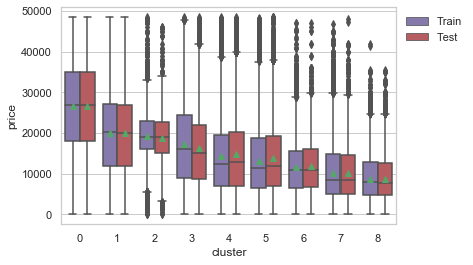

In [487]:
ax = sns.boxplot(x="cluster", y="price"
            ,hue="testtrain", palette=["m", "r"]
            ,showmeans=True
            ,data=df)

ax.legend(bbox_to_anchor=(1,1), edgecolor = 'white')

plt.show()

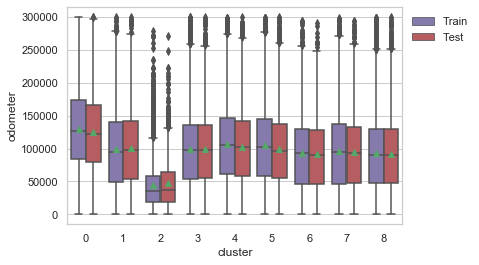

In [488]:
ax = sns.boxplot(x="cluster", y="odometer"
            ,hue="testtrain", palette=["m", "r"]
            ,showmeans=True
            ,data=df)

ax.legend(bbox_to_anchor=(1,1), edgecolor = 'white')

plt.show()

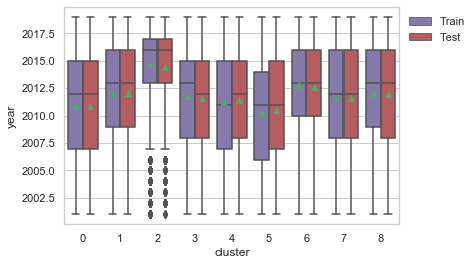

In [490]:
ax = sns.boxplot(x="cluster", y="year"
            ,hue="testtrain", palette=["m", "r"]
            ,showmeans=True
            ,data=df)

ax.legend(bbox_to_anchor=(1,1), edgecolor = 'white')

plt.show()

In [ ]:
#what are the attributes of seg 0 , they are the most valueble, have higher millange and look to be a bit older 

type                 SUV  convertible  coupe  hatchback  mini-van  other  \
cluster testtrain                                                          
0       Test         167            0      0          0         0    167   
        Train        363            0      2          0         1    298   
1       Test           0            0      0          0         0      0   
        Train          0            0      0          0         0      0   
2       Test           5           25    725        144         5    567   
        Train         23          300   3070        435         7   2171   
3       Test           0           90    143        183        46    250   
        Train          0          251    310        537        99    718   
4       Test       11359            0      0          0         0      0   
        Train      29727            0      0          0         0      0   
5       Test        1165          753   1012         65        40    203   
        Train       2720         1600   2798        123        92    711   
6       Test        3798            0      0          0         0      0   
        Train       9588            0      0          0         0      0   
7       Test           0          263    855       1769      1126    688   
        Train          0          746   2356       4079      2756   2273   
8       Test           0            0      0          0         0      0   
        Train          0            0      0          0         0      0   

type               pickup  sedan  truck   van  wagon  
cluster testtrain                                     
0       Test         1678     11   1555    27     10  
        Train        6302     19   5457   332     17  
1       Test         4209      0      0     0      0  
        Train       13571      0      0     0      0  
2       Test           78     46     23    67     73  
        Train         272    217     77   250    155  
3       Test            0   1989   4054   124   1210  
        Train           0   4654  14561   141   2851  
4       Test            0      0      0     0      0  
        Train           0      0      0     0      0  
5       Test         1209   2502   1350   767     70  
        Train        2799   5302   3323  2015    447  
6       Test            0      0      0     0      0  
        Train           0      0      0     0      0  
7       Test          364      0    120   788    833  
        Train         792      0    262  1909   2003  
8       Test            0  11586      0     0      0  
        Train           0  30597      0     0      0

type                SUV  convertible  coupe  hatchback  mini-van  other  \
cluster testtrain                                                         
0       Test       0.05         0.00   0.00       0.00      0.00   0.05   
        Train      0.03         0.00   0.00       0.00      0.00   0.02   
1       Test       0.00         0.00   0.00       0.00      0.00   0.00   
        Train      0.00         0.00   0.00       0.00      0.00   0.00   
2       Test       0.00         0.01   0.41       0.08      0.00   0.32   
        Train      0.00         0.04   0.44       0.06      0.00   0.31   
3       Test       0.00         0.01   0.02       0.02      0.01   0.03   
        Train      0.00         0.01   0.01       0.02      0.00   0.03   
4       Test       1.00         0.00   0.00       0.00      0.00   0.00   
        Train      1.00         0.00   0.00       0.00      0.00   0.00   
5       Test       0.13         0.08   0.11       0.01      0.00   0.02   
        Train      0.12         0.07   0.13       0.01      0.00   0.03   
6       Test       1.00         0.00   0.00       0.00      0.00   0.00   
        Train      1.00         0.00   0.00       0.00      0.00   0.00   
7       Test       0.00         0.04   0.13       0.26      0.17   0.10   
        Train      0.00         0.04   0.14       0.24      0.16   0.13   
8       Test       0.00         0.00   0.00       0.00      0.00   0.00   
        Train      0.00         0.00   0.00       0.00      0.00   0.00   

type               pickup  sedan  truck   van  wagon  
cluster testtrain                                     
0       Test         0.46   0.00   0.43  0.01   0.00  
        Train        0.49   0.00   0.43  0.03   0.00  
1       Test         1.00   0.00   0.00  0.00   0.00  
        Train        1.00   0.00   0.00  0.00   0.00  
2       Test         0.04   0.03   0.01  0.04   0.04  
        Train        0.04   0.03   0.01  0.04   0.02  
3       Test         0.00   0.25   0.50  0.02   0.15  
        Train        0.00   0.19   0.60  0.01   0.12  
4       Test         0.00   0.00   0.00  0.00   0.00  
        Train        0.00   0.00   0.00  0.00   0.00  
5       Test         0.13   0.27   0.15  0.08   0.01  
        Train        0.13   0.24   0.15  0.09   0.02  
6       Test         0.00   0.00   0.00  0.00   0.00  
        Train        0.00   0.00   0.00  0.00   0.00  
7       Test         0.05   0.00   0.02  0.12   0.12  
        Train        0.05   0.00   0.02  0.11   0.12  
8       Test         0.00   1.00   0.00  0.00   0.00  
        Train        0.00   1.00   0.00  0.00   0.00

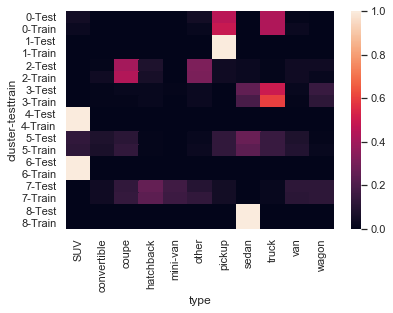

In [491]:
a =  pd.pivot_table(data=df
                     ,values = 'id'
                     ,index = ['cluster','testtrain']
                     ,columns = ['type']
                     ,aggfunc=np.count_nonzero
                     ,fill_value = 0)  

display(a)

a_perc = a.apply(lambda x: x/x.sum(), axis=1)

a_perc = round(a_perc,2)

display(a_perc)

sns.heatmap(a_perc)
#seg 0 are  more likley to be trucks and and much more likley to be pickups
#seg 1 directly below are more likley to be trucks as well 

fuel               diesel    gas
cluster testtrain               
0       Test         3615      0
        Train       12791      0
1       Test            0   4209
        Train           0  13571
2       Test            9   1749
        Train          31   6946
3       Test            0   8089
        Train           0  24122
4       Test            0  11359
        Train           0  29727
5       Test           83   9053
        Train         199  21731
6       Test            3   3795
        Train          11   9577
7       Test          123   6683
        Train         275  16901
8       Test          204  11382
        Train         671  29926

fuel               diesel   gas
cluster testtrain              
0       Test         1.00  0.00
        Train        1.00  0.00
1       Test         0.00  1.00
        Train        0.00  1.00
2       Test         0.01  0.99
        Train        0.00  1.00
3       Test         0.00  1.00
        Train        0.00  1.00
4       Test         0.00  1.00
        Train        0.00  1.00
5       Test         0.01  0.99
        Train        0.01  0.99
6       Test         0.00  1.00
        Train        0.00  1.00
7       Test         0.02  0.98
        Train        0.02  0.98
8       Test         0.02  0.98
        Train        0.02  0.98

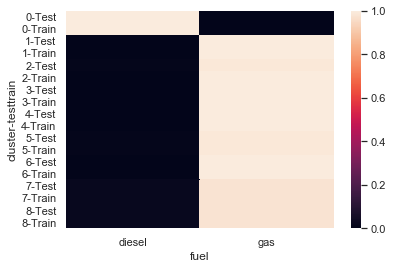

In [492]:
a =  pd.pivot_table(data=df
                     ,values = 'id'
                     ,index = ['cluster','testtrain']
                     ,columns = ['fuel']
                     ,aggfunc=np.count_nonzero
                     ,fill_value = 0)  

a_perc = a.apply(lambda x: x/x.sum(), axis=1)

a_perc = round(a_perc,2)

display(a)
display(a_perc)

sns.heatmap(a_perc)
#seg 0 are diesels! / this is the split between 0 and 1 

transmission       automatic  manual  other
cluster testtrain                          
0       Test            3459     124     32
        Train          12206     424    161
1       Test            3847      72    290
        Train          11709     163   1699
2       Test               0     373   1385
        Train              0     988   5989
3       Test            7620     417     52
        Train          22894    1056    172
4       Test           10894     365    100
        Train          28297     989    441
5       Test            8845     291      0
        Train          21195     735      0
6       Test            3715      54     29
        Train           9043     177    368
7       Test            6206     599      1
        Train          15654    1522      0
8       Test           10559     522    505
        Train          27573    1339   1685

transmission       automatic  manual  other
cluster testtrain                          
0       Test            0.96    0.03   0.01
        Train           0.95    0.03   0.01
1       Test            0.91    0.02   0.07
        Train           0.86    0.01   0.13
2       Test            0.00    0.21   0.79
        Train           0.00    0.14   0.86
3       Test            0.94    0.05   0.01
        Train           0.95    0.04   0.01
4       Test            0.96    0.03   0.01
        Train           0.95    0.03   0.01
5       Test            0.97    0.03   0.00
        Train           0.97    0.03   0.00
6       Test            0.98    0.01   0.01
        Train           0.94    0.02   0.04
7       Test            0.91    0.09   0.00
        Train           0.91    0.09   0.00
8       Test            0.91    0.05   0.04
        Train           0.90    0.04   0.06

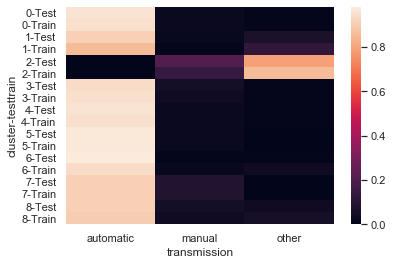

In [493]:
a =  pd.pivot_table(data=df
                     ,values = 'id'
                     ,index = ['cluster','testtrain']
                     ,columns = ['transmission']
                     ,aggfunc=np.count_nonzero
                     ,fill_value = 0)  

a_perc = a.apply(lambda x: x/x.sum(), axis=1)

a_perc = round(a_perc,2)

display(a)
display(a_perc)

sns.heatmap(a_perc)
#seg 8 are diesels! 

drive                4wd    fwd    rwd
cluster testtrain                     
0       Test        3154     49    412
        Train      11398     99   1294
1       Test        4209      0      0
        Train      13571      0      0
2       Test         137    610   1011
        Train        528   2265   4184
3       Test        8089      0      0
        Train      24122      0      0
4       Test       11359      0      0
        Train      29727      0      0
5       Test           0      0   9136
        Train          0      0  21930
6       Test           0   3798      0
        Train          0   9588      0
7       Test           0   6806      0
        Train          0  17176      0
8       Test           0  11586      0
        Train          0  30597      0

drive               4wd   fwd   rwd
cluster testtrain                  
0       Test       0.87  0.01  0.11
        Train      0.89  0.01  0.10
1       Test       1.00  0.00  0.00
        Train      1.00  0.00  0.00
2       Test       0.08  0.35  0.58
        Train      0.08  0.32  0.60
3       Test       1.00  0.00  0.00
        Train      1.00  0.00  0.00
4       Test       1.00  0.00  0.00
        Train      1.00  0.00  0.00
5       Test       0.00  0.00  1.00
        Train      0.00  0.00  1.00
6       Test       0.00  1.00  0.00
        Train      0.00  1.00  0.00
7       Test       0.00  1.00  0.00
        Train      0.00  1.00  0.00
8       Test       0.00  1.00  0.00
        Train      0.00  1.00  0.00

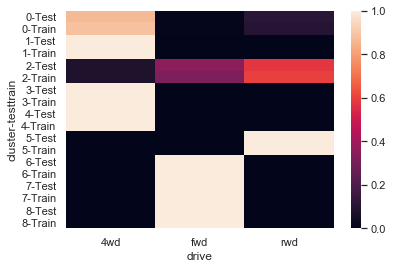

In [494]:
a =  pd.pivot_table(data=df
                     ,values = 'id'
                     ,index = ['cluster','testtrain']
                     ,columns = ['drive']
                     ,aggfunc=np.count_nonzero
                     ,fill_value = 0)  

a_perc = a.apply(lambda x: x/x.sum(), axis=1)

a_perc = round(a_perc,2)

display(a)
display(a_perc)

sns.heatmap(a_perc)
#seg 8 are diesels! 

# standard scaller 

In [270]:
# #scale the numeric variables 

# scaler = StandardScaler()
# scaler.fit(df_gd)
# data_transformed = scaler.transform(df_gd)


In [271]:
#data_transformed.shape

(166479, 22)

In [272]:
#data_transformed.max() 


7.51438615654204

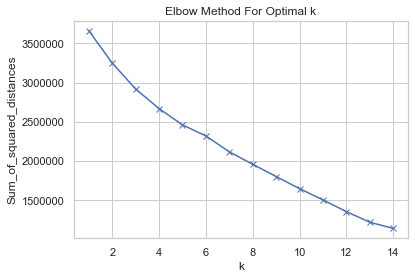

In [273]:
# Sum_of_squared_distances = []
# K = range(1,15)
# for k in K:
#     km = KMeans(n_clusters=k)
#     km = km.fit(data_transformed)
#     Sum_of_squared_distances.append(km.inertia_)

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()    